# Publishing Figures - Single Kappa (free troposphere)
This obtains all figures for a comparison between two simulations of neighbouring optical depth that require the free troposphere as well as surface variables.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
from sklearn.linear_model import TheilSenRegressor
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-02-19 16:53:23,159 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag', 't_ref']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'aquaplanet/temp_tendency/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

Also get an equivalent dataset consisting of free troposphere rather than surface values: `ds_all_ft`.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [4]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
season = 'all'
# season = 'summer'   # NOTE - if summer, does not give many days corresponding to high percentiles as only 5 years of data used

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(pfull=[np.inf, pressure_ft], method='nearest').sel(time=slice(use_time_start, np.inf))

        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)
p_surface = float(ds_all[0].pfull[0]) * 100
pressure_ft_actual = float(ds_all[0].pfull[-1]) * 100       # Actual pressure of free troposphere (Pa)

100%|██████████| 2/2 [00:15<00:00,  7.80s/it]


In [5]:
# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine
lat_use = np.where((np.abs(ds_all[0].lat) <= lat_max) & (np.abs(ds_all[0].lat) >= lat_min))[0]
n_lat_use = len(lat_use)
lat_weights_use = lat_weights[lat_use]

In [6]:
get_all_lat_data = False        # Only get data for latitudes in above cell

# Get values averaged around a surface temperature percentile, rather than exactly on it.
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
n_lat = ds_all[0].lat.shape[0]
n_pressure = ds_all[0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine

# Note the quant3_type doesn't make much difference and only really makes a difference in the tropics
# where the equivalence of the temperature and moist static energy percentiles is not as valid.
quant3_method = 'temp'            # Take percentile to be temperature percentile      (this is legacy, what I was doing previously)
# quant3_method = 'mse'             # Take percentile to be of near-surface mse (think this is correct version of theory)
temp_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant)) 
temp_median = np.zeros((n_exp, n_pressure, n_lat))
temp_mean = np.zeros((n_exp, n_pressure, n_lat))   
# In free troposphere, this is saturated MSE.
mse_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant))  
mse_mean = np.zeros((n_exp, n_pressure, n_lat))
sphum_quant3 = np.zeros((n_exp, n_lat, n_quant))
with tqdm(total=n_exp*n_quant*(n_lat if get_all_lat_data else n_lat_use), position=0, leave=True) as pbar:
    for i in range(n_exp):
        mse = moist_static_energy(ds_all[i].temp[0], ds_all[i].sphum[0], ds_all[i].height[0])
        mse_ft = moist_static_energy(ds_all[i].temp[-1], sphum_sat(ds_all[i].temp[-1], pressure_ft_actual), ds_all[i].height[-1])
        mse_mean[i, 0] = mse.mean(dim='lon_time')
        mse_mean[i, 1] = mse_ft.mean(dim='lon_time')
        temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')
        temp_median[i] = ds_all[i].temp.median(dim='lon_time')
        for k in range(n_lat):
            if not get_all_lat_data:
                if k not in lat_use:
                    # Skip latitudes if don't need them all
                    continue
            for j, quant in enumerate(quant_plot):
                if quant3_method == 'temp':
                    use_ind = get_quant_ind(ds_all[i].temp[0, k], quant, 0.5, 0.5)
                elif quant3_method == 'mse':
                    use_ind = get_quant_ind(mse[k], quant, 0.5, 0.5)
                else:
                    raise ValueError('quant3_type not valid')
                temp_quant3[i, :, k, j] = ds_all[i].temp[:, k, use_ind].mean(dim='lon_time')
                mse_quant3[i, 0, k, j] = mse[k, use_ind].mean(dim='lon_time')           # this is the same as mse_quant2 if quant3_type == mse
                mse_quant3[i, 1, k, j] = mse_ft[k, use_ind].mean(dim='lon_time')
                sphum_quant3[i, k, j] = ds_all[i].sphum[0, k, use_ind].mean(dim='lon_time')     # 0 means surface
                pbar.update(1)

100%|██████████| 2772/2772 [00:16<00:00, 166.31it/s]


## $\lambda_1$ Problem
Below, I show that $\lambda_1 = \delta h(x)/\delta h^*_{FT}(x)>1$ for all $x$ (blue line), and is larger for small $x$ when convection is not taking place. But the assumption of convective quasi-equilibrium expects $\lambda_1 \approx 1$.

I want to come up with a theory to explain why we don't see $\lambda_1 \approx 1$.

In [7]:
lambda_1 = (mse_quant3[1] - mse_quant3[0])[0] / (mse_quant3[1]-mse_quant3[0])[1]
lambda_2 = (mse_quant3[1]-mse_quant3[0])[1] / np.expand_dims(mse_mean[1]-mse_mean[0], axis=-1)[1]
lambda_3 = (mse_mean[1]-mse_mean[0])[0] / (mse_mean[1]-mse_mean[0])[1]
labels = ['$\lambda(x) = \lambda_1(x) \lambda_2(x) / \overline{\lambda_1}$',
          '$\lambda_1(x)$',
          '$\lambda_2(x)$',
          '$\overline{\lambda_1}$']
percentile_label = 'Temperature percentile, $x$' if quant3_method == 'temp' else 'MSE percentile, $x$'

/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_89389/1680755996.py:1: RuntimeWarning: invalid value encountered in true_divide
  lambda_1 = (mse_quant3[1] - mse_quant3[0])[0] / (mse_quant3[1]-mse_quant3[0])[1]


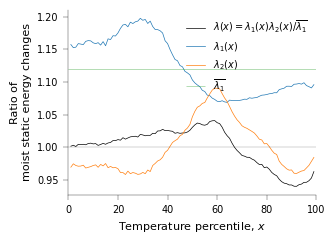

In [276]:
save_lambda_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i, var in enumerate([lambda_1*lambda_2/np.expand_dims(lambda_3, axis=-1), lambda_1, lambda_2]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(quant_plot, np.average(var[lat_use], axis=0, weights=lat_weights_use),
            color=use_color, label=labels[i])
# ax.plot(quant_plot, np.average(lambda_1, axis=0, weights=lat_weights), color=default_colors[0], label=labels[1])
# ax.plot(quant_plot, np.average(lambda_2, axis=0, weights=lat_weights), color=default_colors[1])
ax.hlines(np.average(lambda_3[lat_use], axis=0, weights=lat_weights_use), 0, 100, color=default_colors[2], alpha=0.5, label=labels[3])
ax.hlines(1, 0, 100, color='k', lw=ax_linewidth, alpha=0.5)
ax.legend()
ax.set_xlim(0, 100)
# ax.set_ylim(0.93, 1.27)
ax.set_xlabel(percentile_label)
ax.set_ylabel('Ratio of\nmoist static energy changes')
if save_fig or save_lambda_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## $\epsilon$ Formulation
Below I show that $\lambda_1(x) > 1$ is equivalent to $\epsilon(x) > 0$, where $\epsilon$ is defined through $h(x) = h^*_{FT}(x) + \epsilon(x)$. I.e. it represents CAPE.

I try to explain this increase in $\epsilon$ through a shift in the x and y direction:
$\epsilon^{hot}(x) = \epsilon^{cold}(x-\mu) + \xi$
* $\mu$ is  related to $\delta x_c$ where $x_c$ is the temperature percentile went convection dominates i.e. $\epsilon(x_c) = 0$.
* $\xi$ is going to be related to the systematic increase in CAPE on convective days, $\delta \epsilon_{conv}$.

Doing a taylor series, we then find:
$\delta \epsilon (x) \approx \xi - \mu \frac{d\epsilon^{cold}}{dx}|_x$

So $\xi$ and $\mu$ can be found through linear regression, as shown in the top plot below. I ignore the coldest 10 and warmest 5 quantiles when doing this regression as their $\frac{d\epsilon^{cold}}{dx}$ values are significantly different. I also use the `TheilSenRegressor` regression, so it is more robust to outliers.

This example is using $\delta \epsilon (x)$ and $\frac{d\epsilon^{cold}}{dx}|_x$ from all latitudes in the tropics combined.

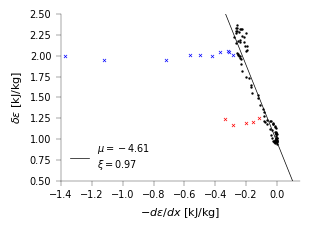

In [9]:
# Show how fitting is done when combining all latitudes
def do_epsilon_fitting(epsilon_cold, epsilon_warm, ignore_extremes_cold=10, ignore_extremes_hot=5, temp_cold=None):
    """
    Returns mu and xi such that delta_epsilon = xi - mu * d_epsilon_d_x
    
    Args:
        epsilon_cold: [n_quant]
        epsilon_warm: [n_quant]
        ignore_extremes_cold: `int`, The first values indicated by this are not used in fitting.
        ignore_extremes_hot: `int`, The last values indicated by this are not used in fitting.

    Returns:
        gradient, mu
        intercept, xi
    """
    # Was thinking, could also do this by weighting preferentially to points with small distance to 5th nearest neighbour
    if ignore_extremes_hot == 0:
        ignore_extremes_hot = None      # need to set this to None to use all hot quantiles
    else:
        ignore_extremes_hot = -np.abs(ignore_extremes_hot)      # make negative, so ignore last values
    if temp_cold is None:
        d_epsilon_d_x = np.gradient(epsilon_cold)[ignore_extremes_cold:ignore_extremes_hot]
    else:
        # Do derivative wrt temperature rather than with respect to x
        d_epsilon_d_x = np.gradient(epsilon_cold, temp_cold)[ignore_extremes_cold:ignore_extremes_hot]
    epsilon_diff = (epsilon_warm - epsilon_cold)[ignore_extremes_cold:ignore_extremes_hot]
    # This ignores outliers well (unlike polyfit), which is important
    if epsilon_warm.min() > 0.5:
        # If all days are convecting in warm simulation, then don't need to worry about shift of convective threshold
        # Just return a change to the CAPE
        return 0, np.median(epsilon_diff)
    else:
        estimator = TheilSenRegressor(random_state=42)          
        estimator.fit(-d_epsilon_d_x[:, np.newaxis], epsilon_diff)
        return estimator.coef_[0], estimator.intercept_

# Note I compute epsilon as the differences of the mean
# It is the same value if I compute it as the mean of the differences i.e. compute it inside the for loop.
epsilon_quant3 = mse_quant3[:, 0] - mse_quant3[:, 1]            # surface - free trop MSE

fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
fit_extremes_ignore=[10, 5]       # don't use first 10 or last 5 points for fitting
ax.scatter(-np.gradient(np.average(epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use)
                        )[fit_extremes_ignore[0]:-fit_extremes_ignore[1]], 
            np.average(epsilon_quant3[1, lat_use] - epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use
                       )[fit_extremes_ignore[0]:-fit_extremes_ignore[1]], s=0.5, color='k')
# Show in blue, cold days not used in fitting
ax.scatter(-np.gradient(np.average(epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use)
                        )[:fit_extremes_ignore[0]], 
            np.average(epsilon_quant3[1, lat_use] - epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use
                       )[:fit_extremes_ignore[0]], s=5, color='blue', marker='x')
# Show in red, hot days not used in fitting
ax.scatter(-np.gradient(np.average(epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use)
                        )[-fit_extremes_ignore[1]:], 
            np.average(epsilon_quant3[1, lat_use] - epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use
                       )[-fit_extremes_ignore[1]:], s=5, color='red', marker='x')

mu_combine_lat, xi_combine_lat = do_epsilon_fitting(np.average(epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use), 
                                                    np.average(epsilon_quant3[1, lat_use], axis=0, weights=lat_weights_use),
                                                    fit_extremes_ignore[0], fit_extremes_ignore[1])
ax.plot(np.arange(-1.5, 1, 0.1), np.arange(-1.5, 1, 0.1)*mu_combine_lat + xi_combine_lat, color='k', 
        label=f'$\mu={round(mu_combine_lat, 2)}$\n$\\xi={round(xi_combine_lat, 2)}$')
ax.legend(loc='lower left')
ax.set_ylim(0.5, 2.5)
ax.set_xlim(-1.4, 0.15)
ax.set_xlabel('$-d\epsilon/dx$ [kJ/kg]')
ax.set_ylabel('$\delta \epsilon$ [kJ/kg]')
plt.tight_layout()

### $\mu$ and $\xi$ as function of latitude
Below I compute $\mu$ and $\xi$ as a function of latitude. Clearly both $\mu$ and $\xi$ decrease with latitude.

Near the equator, basically all days are convecting $\epsilon^{hot}(x) > 0$ for all $x$. Thus $\mu$ doesn't make any sense. Thus, I force $\mu$ to be zero in this case and just take $\xi$ using the median of $\delta \epsilon$.

The $\mu$ computed in the above figure is shown by the dotted line in the top plot below. The $\mu$ found by finding the value for each latitude and then computing an average is shown by the dashed line. Clearly they are quite different. On the other hand the two average $\xi$ values are very similar.

The figure below this shows the predicted $\epsilon^{hot}$ as a dotted line for each latitude. They seem pretty good.

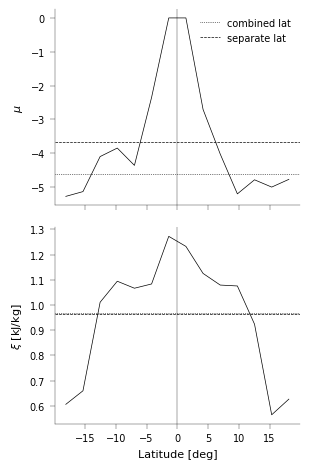

In [10]:
# Computing mu and xi for each latitude separately
mu_lat = np.zeros(n_lat)
xi_lat = np.zeros(n_lat)
for i in range(n_lat_use):
    mu_lat[lat_use[i]], xi_lat[lat_use[i]] = do_epsilon_fitting(epsilon_quant3[0, lat_use[i]], epsilon_quant3[1, lat_use[i]],
                                                                fit_extremes_ignore[0], fit_extremes_ignore[1])

fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
ax[0].plot(ds_all[0].lat[lat_use], mu_lat[lat_use], color='k')
ax[1].plot(ds_all[0].lat[lat_use], xi_lat[lat_use], color='k')
ax[0].axhline(mu_combine_lat, color='k', linestyle=':', label='combined lat')
ax[0].axhline(np.average(mu_lat[lat_use], axis=0, weights=lat_weights_use), color='k', label='separate lat', linestyle='--')
ax[1].axhline(np.average(xi_lat[lat_use], axis=0, weights=lat_weights_use), color='k', linestyle='--')
ax[1].axhline(xi_combine_lat, color='k', linestyle=':')
ax[0].set_ylabel('$\mu$')
ax[1].set_ylabel('$\\xi$ [kJ/kg]')
ax[1].set_xlabel('Latitude [deg]')
ax[0].axvline(0, color='k', lw=ax_linewidth)
ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[0].legend()
plt.tight_layout()

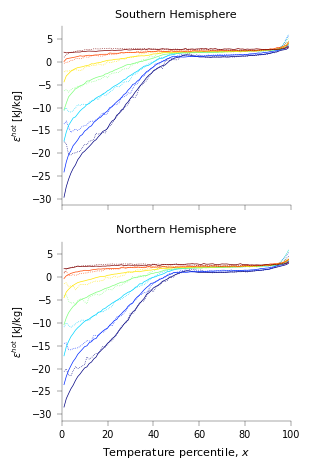

In [11]:
# In solid, is the simulated epsilon for the warm simulation.
# In dotted, is the predicted epsilon using the above formulation, applied to each latitude individually.
save_epsilon_predict_lat_fig = False
colors_lat = plt.cm.jet(np.linspace(0, 1, int(n_lat_use/2)))
fig_lat, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True, sharey=True)
for i in range(int(n_lat_use/2)):
    ax[0].plot(quant_plot, epsilon_quant3[1, lat_use[i]], color=colors_lat[i])
    ax[0].plot(quant_plot, epsilon_quant3[0, lat_use[i]] + 
               xi_lat[lat_use[i]]-mu_lat[lat_use[i]]*np.gradient(epsilon_quant3[0, lat_use[i]]), color=colors_lat[i], linestyle=':')
    ax[1].plot(quant_plot, epsilon_quant3[1, lat_use[-i-1]], color=colors_lat[i])
    ax[1].plot(quant_plot, epsilon_quant3[0, lat_use[-i-1]] + 
               xi_lat[lat_use[-i-1]]-mu_lat[lat_use[-i-1]]*np.gradient(epsilon_quant3[0, lat_use[-i-1]]), color=colors_lat[i], linestyle=':')
ax[0].set_xlim(0, 100)
ax[-1].set_xlabel(percentile_label)
ax[0].set_ylabel('$\epsilon^{hot}$ [kJ/kg]', fontsize=7)
ax[1].set_ylabel('$\epsilon^{hot}$ [kJ/kg]', fontsize=7)
ax[0].set_title('Southern Hemisphere')
ax[1].set_title('Northern Hemisphere')
plt.tight_layout()
# plt.ylim(-3, 3)

if save_fig or save_epsilon_predict_lat_fig:
    fig_lat.savefig(f"/Users/joshduffield/Desktop/epsilon_predict_lat_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Combined latitude
Below I plot $\epsilon$ and $\delta \epsilon$ combining all latitudes in the tropics.

I also show two theoretical predictions for $\delta \epsilon$ using $\delta \epsilon (x) \approx \xi - \mu \frac{d\epsilon^{cold}}{dx}|_x$. The dotted line uses the $\mu$ and $\xi$ computed from the combined latitudes. The dashed line uses $\mu$ and $\xi$ for each latitude separately. I.e. $\delta \epsilon$ is predicted for each latitude separately and then a weighted average is performed. Both methods are basically identical.

In the top plot, I add these theoretical $\delta \epsilon$ values to $\epsilon^{cold}$ so it should overlap with $\epsilon^{hot}$.

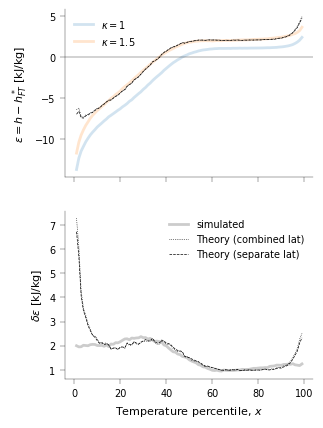

In [22]:
save_epsilon_fig = True
fig_epsilon, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quant_plot, np.average(epsilon_quant3[i, lat_use], axis=0, weights=lat_weights_use),
               color=default_colors[i], label=f'$\kappa={tau_lw[i]}$', lw=2, alpha=0.2)
ax[1].plot(quant_plot, np.average(epsilon_quant3[1, lat_use] - epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use), color='k',
           label='simulated', lw=2, alpha=0.2)

# Theoretical prediction using mu and xi from combined lat
ax[0].plot(quant_plot, np.average(epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use)+
           xi_combine_lat-mu_combine_lat*np.gradient(np.average(epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use)), 
           linestyle=':', color='k')
ax[1].plot(quant_plot, xi_combine_lat-mu_combine_lat*np.gradient(np.average(epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use)), 
           linestyle=':', color='k', label='Theory (combined lat)')

# Theoretical prediction for each lat and then taking average
ax[0].plot(quant_plot, np.average((epsilon_quant3[0]+
           xi_lat[:, np.newaxis]-mu_lat[:, np.newaxis]*np.gradient(epsilon_quant3[0], axis=1))[lat_use], axis=0, weights=lat_weights_use), 
           linestyle='--', color='k')
ax[1].plot(quant_plot, np.average((xi_lat[:, np.newaxis]-mu_lat[:, np.newaxis]*np.gradient(epsilon_quant3[0], axis=1))[lat_use], 
                                  axis=0, weights=lat_weights_use), 
           linestyle='--', color='k', label='Theory (separate lat)')

ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()
ax[1].legend()
ax[-1].set_xlabel(percentile_label)
# ax[0].set_xlim(0, 100)
ax[0].set_ylabel('$\epsilon = h - h_{FT}^*$ [kJ/kg]')
ax[1].set_ylabel('$\delta \epsilon$ [kJ/kg]')

if save_fig or save_epsilon_fig:
    fig_epsilon.savefig(f"/Users/joshduffield/Desktop/epsilon_{region.lower()}_{season}.pdf",
                        dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## As function of temperature not percentile
Rather than assuming $\epsilon^{hot}(x) = \epsilon^{cold}(x-\mu) + \xi$, I can think as a function of temperature not percentile.


Doing a taylor expansion, we get: $\delta \epsilon(x) \approx -\mu' \frac{d\epsilon^{cold}}{dT}|_x + \xi$ or $\delta \epsilon(x) \approx -\mu' \frac{dx^{cold}}{dT} \frac{d\epsilon^{cold}}{dx} + \xi$
So we are replacing $\mu$ from before with $\mu' \frac{dx}{dT}$ which does depend on $x$. It accounts for the fact that $T$ does not increase uniformly with $x$. As such, it should do better with the extreme hot and cold percentiles.

I think this is saying that for all days with positive CAPE, the CAPE increases uniformly with temperature.

I find $\mu'$ and $\xi$ below by plotting $\delta \epsilon(T)$ vs $\frac{d\epsilon^{cold}}{dT}$.

I now include all quantiles, but I still colour the extreme cold and hot quantiles. Clearly these extremes fit much better to the straight line than when using $d\epsilon/dx$.

**Not sure about this algebra, but final equation works pretty well.**

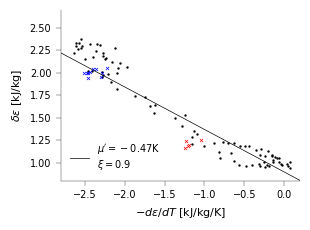

In [107]:
mu_temp_combine_lat, xi_temp_combine_lat = do_epsilon_fitting(np.average(epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use), 
                                                              np.average(epsilon_quant3[1, lat_use], axis=0, weights=lat_weights_use),
                                                              0, 0, np.average(temp_quant3[0, 0, lat_use], axis=0, weights=lat_weights_use))

fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.scatter(-np.gradient(np.average(epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use),
                        np.average(temp_quant3[0, 0, lat_use], axis=0, weights=lat_weights_use))[fit_extremes_ignore[0]:-fit_extremes_ignore[1]], 
            np.average(epsilon_quant3[1, lat_use] - epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use
                       )[fit_extremes_ignore[0]:-fit_extremes_ignore[1]], s=0.5, color='k')
ax.scatter(-np.gradient(np.average(epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use),
                        np.average(temp_quant3[0, 0, lat_use], axis=0, weights=lat_weights_use))[:fit_extremes_ignore[0]], 
            np.average(epsilon_quant3[1, lat_use] - epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use
                       )[:fit_extremes_ignore[0]], s=5, color='blue', marker='x')
ax.scatter(-np.gradient(np.average(epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use),
                        np.average(temp_quant3[0, 0, lat_use], axis=0, weights=lat_weights_use))[-fit_extremes_ignore[1]:], 
            np.average(epsilon_quant3[1, lat_use] - epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use
                       )[-fit_extremes_ignore[1]:], s=5, color='red', marker='x')
ax.plot(np.arange(-4, 1, 0.1), np.arange(-4, 1, 0.1)*mu_temp_combine_lat + xi_temp_combine_lat, color='k', 
        label=f"$\mu'={round(mu_temp_combine_lat, 2)}$K\n$\\xi={round(xi_temp_combine_lat, 2)}$")
ax.set_xlim(-2.8, 0.2)
ax.set_ylim(0.8, 2.7)
ax.legend(loc='lower left')
ax.set_xlabel('$-d\epsilon/dT$ [kJ/kg/K]')
ax.set_ylabel('$\delta \epsilon$ [kJ/kg]')
plt.tight_layout()

### Latitude Analysis
Below I repeat the analysis to compute $\mu'$ and $\xi$ as a function of latitude. The new theoretical $\epsilon^{hot}$ values are plotted as dashed lines.

The trend of $\mu'$ with latitude is very similar to the $\mu$ trend. The $\xi$ values are also very similar.

In [14]:
# Computing mu and xi for each latitude separately
mu_temp_lat = np.zeros(n_lat)
xi_temp_lat = np.zeros(n_lat)
for i in range(n_lat_use):
    mu_temp_lat[lat_use[i]], xi_temp_lat[lat_use[i]] = do_epsilon_fitting(epsilon_quant3[0, lat_use[i]], epsilon_quant3[1, lat_use[i]],
                                                                          0, 0, temp_quant3[0, 0, lat_use[i]])
d_epsilon_d_temp = np.asarray([[np.gradient(epsilon_quant3[i, k], temp_quant3[i, 0, k]) for k in range(n_lat)] for i in range(n_exp)])

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/numpy/lib/function_base.py:1211: RuntimeWarning: invalid value encountered in true_divide
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/numpy/lib/function_base.py:1232: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/numpy/lib/function_base.py:1239: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n


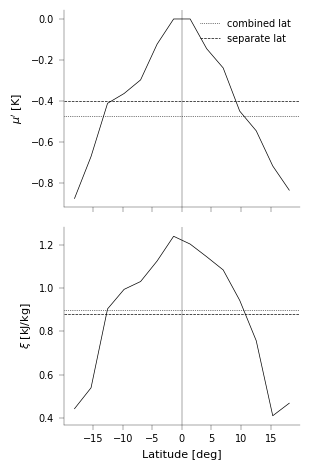

In [15]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
ax[0].plot(ds_all[0].lat[lat_use], mu_temp_lat[lat_use], color='k')
ax[1].plot(ds_all[0].lat[lat_use], xi_temp_lat[lat_use], color='k')
ax[0].axhline(mu_temp_combine_lat, color='k', linestyle=':', label='combined lat')
ax[0].axhline(np.average(mu_temp_lat[lat_use], axis=0, weights=lat_weights_use), color='k', label='separate lat', linestyle='--')
ax[1].axhline(np.average(xi_temp_lat[lat_use], axis=0, weights=lat_weights_use), color='k', linestyle='--')
ax[1].axhline(xi_temp_combine_lat, color='k', linestyle=':')
ax[0].set_ylabel("$\mu'$ [K]")
ax[1].set_ylabel('$\\xi$ [kJ/kg]')
ax[1].set_xlabel('Latitude [deg]')
ax[0].axvline(0, color='k', lw=ax_linewidth)
ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[0].legend()
plt.tight_layout()

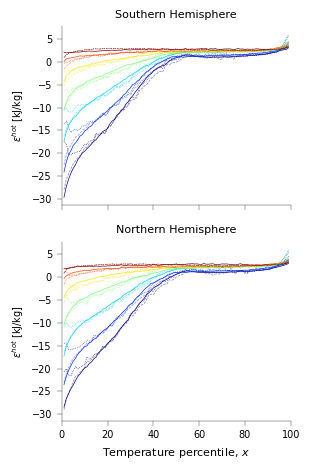

In [16]:
fig = copy.deepcopy(fig_lat)
ax = fig.axes
for i in range(int(n_lat_use/2)):
    ax[0].plot(quant_plot, epsilon_quant3[0, lat_use[i]] + 
               xi_temp_lat[lat_use[i]]-mu_temp_lat[lat_use[i]]*d_epsilon_d_temp[0, lat_use[i]], color=colors_lat[i], 
               linestyle='--', alpha=0.5)
    ax[1].plot(quant_plot, epsilon_quant3[0, lat_use[-i-1]] + 
               xi_temp_lat[lat_use[-i-1]]-mu_temp_lat[lat_use[-i-1]]*d_epsilon_d_temp[0, lat_use[-i-1]], color=colors_lat[i],
               linestyle='--', alpha=0.5)   
if save_fig or save_epsilon_predict_lat_fig:
    fig_lat.savefig(f"/Users/joshduffield/Desktop/epsilon_predict_lat_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)
fig

### Combine Latitudes
Below, I combine all the latitudes in the tropics to show that the new theory in terms of $d\epsilon/dT$ rather than $d\epsilon/dx$ performs better, especially at the extreme latitudes.

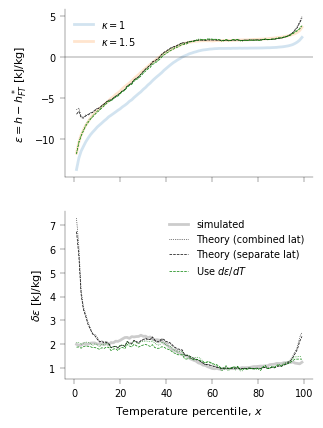

In [66]:
fig = copy.deepcopy(fig_epsilon)
ax = fig.axes
ax[0].plot(quant_plot, np.average(epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use)+xi_temp_combine_lat-mu_temp_combine_lat*
           np.gradient(np.average(epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use), 
                       np.average(temp_quant3[0, 0, lat_use], axis=0, weights=lat_weights_use)), 
           linestyle=':', color='green')
ax[1].plot(quant_plot, xi_temp_combine_lat-mu_temp_combine_lat*
           np.gradient(np.average(epsilon_quant3[0, lat_use], axis=0, weights=lat_weights_use), 
                       np.average(temp_quant3[0, 0, lat_use], axis=0, weights=lat_weights_use)), 
           linestyle=':', color='green')

ax[0].plot(quant_plot, np.average((epsilon_quant3[0]+xi_temp_lat[:, np.newaxis]-mu_temp_lat[:, np.newaxis]*d_epsilon_d_temp[0])[lat_use],
                                  axis=0, weights=lat_weights_use), 
           linestyle='--', color='green')
ax[1].plot(quant_plot, np.average((xi_temp_lat[:, np.newaxis]-mu_temp_lat[:, np.newaxis]*d_epsilon_d_temp[0])[lat_use], 
                                  axis=0, weights=lat_weights_use), 
           linestyle='--', color='green', label='Use $d\epsilon/dT$')
ax[1].legend()

if save_fig or save_epsilon_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/epsilon_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)
fig

### $dT/dx$ Plot
The difference between the green and black dashed lines above is due to $dT/dx$ not being constant with $x$. As is shown below, $dT/dx$ is a lot larger for extreme percentiles - hence the black lines are so much worse for extreme percentiles.

$dT/dx$ does not seem to vary much with warming, which may be a useful approximation to use.

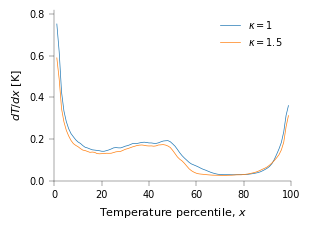

In [458]:
lat_use_h_plot = lat_use[-3:]
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(2):
    ax.plot(quant_plot, np.gradient(np.average(temp_quant3[i, 0, lat_use_h_plot], axis=0, weights=lat_weights[lat_use_h_plot])), label=f'$\kappa={tau_lw[i]}$')
ax.set_xlim(0, 100)
ax.legend()
ax.set_ylabel('$dT/dx$ [K]')
ax.set_xlabel(percentile_label)
ax.set_ylim(0, 0.82)
plt.tight_layout()

## Theoretical prediction for $d\epsilon/dT$ for non-convective days
The plot below suggests that in the non-convective regime, $d\epsilon/dT$ is constant and increases with warming. Black lines show my manual guess of $d\epsilon/dT$.

I manually shift the warmer simulation in $T$ and $\epsilon$ so they overlap for the convective days.

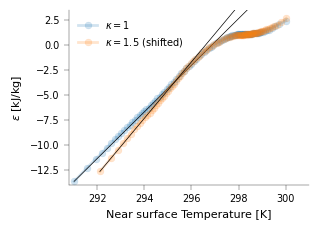

In [266]:
temp_range_predict = 10         # Predict epsilon covering this temperature range
d_epsilon_d_temp_manual = [2.3346, 2.8235294]           # My guess at the gradients in the non-convective regime

fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(np.average(temp_quant3[i, 0, lat_use]-4.1*i, axis=0, weights=lat_weights_use), 
             np.average(epsilon_quant3[i, lat_use], axis=0, weights=lat_weights_use)-1*i,
                   color=default_colors[i], label=f"$\kappa={tau_lw[i]}${' (shifted)' if i==1 else ''}", lw=2, alpha=0.2, marker='o', markersize=5)
    ax.plot(np.average(temp_quant3[i, 0, lat_use], axis=0, weights=lat_weights_use)[0]-4.1*i + np.arange(temp_range_predict), 
         np.average(epsilon_quant3[i, lat_use], axis=0, weights=lat_weights_use)[0]-1*i+
             d_epsilon_d_temp_manual[i]* np.arange(temp_range_predict), color='k')
ax.set_ylabel('$\epsilon$ [kJ/kg]')
ax.set_xlabel('Near surface Temperature [K]')
ax.set_xlim(290.8, 301)
ax.set_ylim(-14, 3.5)
ax.legend()
plt.tight_layout()
# plt.ylim(0, 2.8)
# plt.xlim(0.8, 4.3)

### Theory for $d\epsilon/dT$ and $\delta d\epsilon/dT$

The equation for $\epsilon$ is $\epsilon = h(x)-h^*_{FT}(x)$.

In the non-convective regime, $h^*_{FT}(x)$ is constant with $x$ or equally near-surface temperature, $T$, due to WTG. So differentiating the above equation wrt $T$ we get:

$\frac{d\epsilon}{dT} = c_p + L_v\alpha q + L_v q^* \frac{dr}{dT}$

where $r$ is relative humidity.

This prediction is shown by the dotted lines in the top plot below. It clearly over-estimates $d\epsilon/dT$ for the coldest days - implying that $dh^*_{FT}/dT$ is slightly positive.

As from above we expect the gradient to be constant for non-convective days, I also use the theory to compute the mean $\frac{d\epsilon}{dT}$. For this, I take as non-convective all $x$ such that $\epsilon(x)<-0.2$ (using $\epsilon$ combined over latitudes. This is $x<37$ ($x<27$) for the $\kappa=1$ ($\kappa=1.5$) simulation.

I then use the theory to compute $\frac{d\epsilon}{dT}$ at each latitude before combining latitudes.

The result is shown by the horizontal dotted lines.

Taking the difference of this between simulations, we get:

$\delta \left(\frac{d\epsilon}{dT}\right) = L_v \alpha q^* \delta r + L_v q^* \delta \left(\frac{dr}{dT}\right) + 
L_v \alpha \left(\frac{q}{T}(\alpha T - 2) + q^* \frac{dr}{dT}\right)\delta T$

For the mean non-convective day, this is shown by the horizontal black line in the bottom plot. The separate components are shown by the coloured lines. From this, we see that the temperature increase between the simulations can explain most of the increase in $d\epsilon/dT$.

In [154]:
def get_d_epsilon_d_temp_theory(temp, sphum, rh_gradient=None):
    # If rh_gradient is None, then temp and sphum need to be arrays of size [n_quant] 
    # Otherwise, can use multi-dimensional arrays e.g. [n_lat, n_quant]
    q_sat = sphum_sat(temp, p_surface)
    rh = sphum / q_sat
    if rh_gradient is None:
        rh_gradient = np.gradient(rh, temp)
    alpha = clausius_clapeyron_factor(temp, p_surface)
    return (c_p + L_v * alpha * sphum + L_v * q_sat * rh_gradient)/1000

r_quant3 = sphum_quant3 / sphum_sat(temp_quant3[:, 0], p_surface)
r_gradient_quant3 = np.zeros_like(r_quant3)
d_epsilon_d_temp_theory = np.zeros_like(r_quant3)
for i in range(n_exp):
    for j in range(n_lat):
        r_gradient_quant3[i, j] = np.gradient(r_quant3[i, j], temp_quant3[i, 0, j], axis=0)
        d_epsilon_d_temp_theory[i, j] = get_d_epsilon_d_temp_theory(temp_quant3[i, 0, j], sphum_quant3[i, j])

In [170]:
# All x less than x_non_conv are non-convecting
epsilon_non_conv_thresh = -2
x_non_conv = [np.argmin(np.abs(np.average(epsilon_quant3[i, lat_use], axis=0, weights=lat_weights_use)-epsilon_non_conv_thresh)) 
              for i in range(n_exp)]
r_gradient_non_conv_mean = np.asarray([np.mean(r_gradient_quant3[i, :, :x_non_conv[i]], axis=-1) for i in range(n_exp)])
temp_non_conv_mean = np.asarray([np.mean(temp_quant3[i, 0, :, :x_non_conv[i]], axis=-1) for i in range(n_exp)])
sphum_non_conv_mean = np.asarray([np.mean(sphum_quant3[i, :, :x_non_conv[i]], axis=-1) for i in range(n_exp)])
d_epsilon_d_temp_non_conv_mean_theory = get_d_epsilon_d_temp_theory(temp_non_conv_mean, sphum_non_conv_mean, r_gradient_non_conv_mean)

In [ ]:
def get_delta_d_epsilon_d_temp_theory(temp, sphum, rh_gradient):
    """
    Args:
        temp: [n_exp, n_lat]
        sphum: [n_exp, n_lat]
        rh_gradient: [n_exp, n_lat]

    Returns:
        [n_lat] full difference
        List of three [n_lat] arrays: rh, d_rh/d_temp and temp contributions
        List of three [n_lat] arrays: rh, d_rh/d_temp and temp prefactors.
    """
    q_sat = sphum_sat(temp, p_surface)
    rh = sphum / q_sat
    alpha = clausius_clapeyron_factor(temp, p_surface)
    r_prefactor = (L_v * alpha * q_sat)[0] / 1000
    dr_dt_prefactor = (L_v * q_sat)[0] / 1000
    temp_prefactor = (L_v * sphum * alpha * (alpha * temp - 2)/temp + L_v * alpha * q_sat * rh_gradient)[0] / 1000
    prefactors = [r_prefactor, dr_dt_prefactor, temp_prefactor]
    diff_contributions = [prefactors[i] * (var[1]-var[0]) for i, var in enumerate([rh, rh_gradient, temp])]
    full_diff = diff_contributions[0] + diff_contributions[1] + diff_contributions[2]
    return full_diff, diff_contributions, prefactors

delta_d_epsilon_d_temp_theory, delta_d_epsilon_d_temp_cont, delta_d_epsilon_d_temp_params = \
    get_delta_d_epsilon_d_temp_theory(temp_non_conv_mean, sphum_non_conv_mean, r_gradient_non_conv_mean)

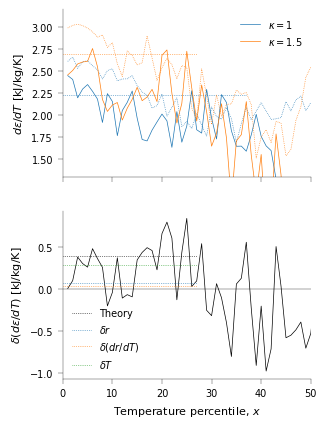

In [269]:
save_d_epsilon_d_temp_theory_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quant_plot, np.average(d_epsilon_d_temp[i, lat_use], axis=0, weights=lat_weights_use), color=default_colors[i],
               label=f'$\kappa={tau_lw[i]}$')
    ax[0].plot(quant_plot, np.average(d_epsilon_d_temp_theory[i, lat_use], axis=0, weights=lat_weights_use), 
             color=default_colors[i], linestyle=':')
    ax[0].hlines(np.average(d_epsilon_d_temp_non_conv_mean_theory[i, lat_use], axis=0, weights=lat_weights_use), 
               0, x_non_conv[i], color=default_colors[i], linestyle=':')
ax[0].legend()
ax[0].set_ylim(1.3, 3.2)
ax[0].set_xlim(0, 50)
ax[0].set_ylabel('$d\epsilon/dT$ [kJ/kg/K]')

ax[1].plot(quant_plot, np.average(d_epsilon_d_temp[1, lat_use]-d_epsilon_d_temp[0, lat_use], axis=0, weights=lat_weights_use), color='k')
ax[1].hlines(np.average(delta_d_epsilon_d_temp_theory[lat_use], axis=0, weights=lat_weights_use), 0, x_non_conv[1], color='k', 
             linestyle=':', label='Theory')
labels_d_epsilon_d_temp = ['$\delta r$', '$\delta (dr/dT)$', '$\delta T$']
for i in range(3):
    ax[1].hlines(np.average(delta_d_epsilon_d_temp_cont[i][lat_use], axis=0, weights=lat_weights_use), 0, x_non_conv[1], 
                 color=default_colors[i], linestyle=':', label=labels_d_epsilon_d_temp[i])
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].legend()
ax[1].set_ylabel('$\delta (d\epsilon/dT)$ [kJ/kg/K]')
ax[1].set_xlabel(percentile_label)
if save_fig or save_d_epsilon_d_temp_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/d_epsilon_d_temp_theory_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

I think it is easier to see how good the theory is by looking at $\epsilon$ vs $T$ rather than $d\epsilon/dT$ vs $x$.

The black lines below show the theoretical mean $d\epsilon/dT$. For the cold simulation, this is an underestimate throughout the non-convective regime, despite the fact that above it is an overestimate for all but the coldest quantiles. I think this might be because the difference in $T$ for most $x$ is very small so the plot against $x$ is deceptive. For the warmer simulation, it is a better match.

The red line for the colder simulation is the manual fit. The red line for the hotter simulation is the manual fit plus the theoretical mean $\delta (d\epsilon/dT)$. This is very close to the black line for the warmer simulation.

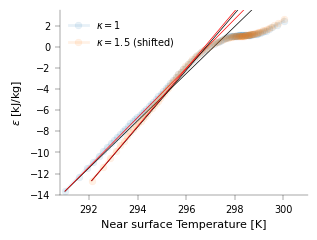

In [270]:
# Predict epsilon from non-convective gradient
save_epsilon_theory_fig = False
epsilon_predict = [np.average(epsilon_quant3[i, lat_use, 0] + 
                              d_epsilon_d_temp_non_conv_mean_theory[i, lat_use]*np.arange(temp_range_predict )[:, np.newaxis],
                              axis=1, weights=lat_weights_use) for i in range(n_exp)]

fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(np.average(temp_quant3[i, 0, lat_use]-4.1*i, axis=0, weights=lat_weights_use), 
             np.average(epsilon_quant3[i, lat_use], axis=0, weights=lat_weights_use)-1*i,
                   color=default_colors[i], label=f"$\kappa={tau_lw[i]}${' (shifted)' if i==1 else ''}",
            lw=2, alpha=0.1, marker='o', markersize=5)
    ax.plot(np.average(temp_quant3[i, 0, lat_use]-4.1*i, axis=0, weights=lat_weights_use)[0] + np.arange(temp_range_predict), epsilon_predict[i]-1*i,
             color='k')
    ax.plot(np.average(temp_quant3[i, 0, lat_use], axis=0, weights=lat_weights_use)[0]-4.1*i + np.arange(temp_range_predict), 
             np.average(epsilon_quant3[i, lat_use], axis=0, weights=lat_weights_use)[0]-1*i+
             (d_epsilon_d_temp_manual[0]+np.average(delta_d_epsilon_d_temp_theory[lat_use], axis=0, weights=lat_weights_use)*i)*
             np.arange(temp_range_predict), color='r')
ax.set_ylabel('$\epsilon$ [kJ/kg]')
ax.set_xlabel('Near surface Temperature [K]')
ax.set_xlim(290.8, 301)
ax.set_ylim(-14, 3.5)
ax.legend()

if save_fig or save_epsilon_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/epsilon_theory_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### $\epsilon$ as function of latitude
A problem with the above is that more convection occurs as you move closer to the equator, so really should have different critical non-convective day, $x_{NC}$ for each latitude. But this would complicate things.

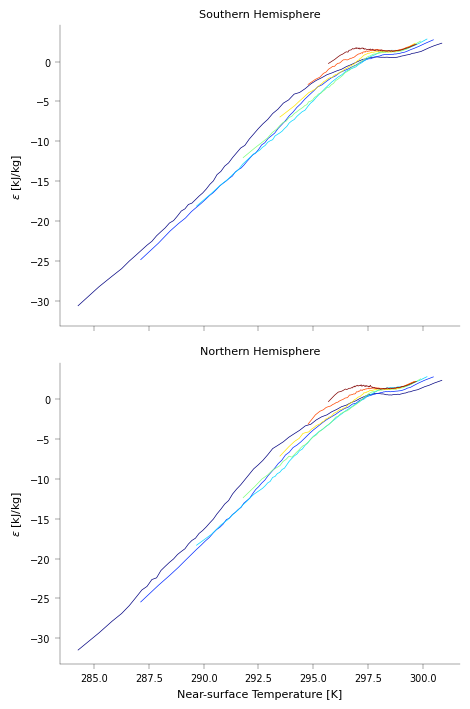

In [275]:
fig_lat, ax = plt.subplots(2,1, figsize=(width['one_col']*1.5, 2*width['one_col']/ar*1.5), sharex=True, sharey=True)
for i in range(int(n_lat_use/2)):
    ax[0].plot(temp_quant3[0, 0, lat_use[i]], epsilon_quant3[0, lat_use[i]], color=colors_lat[i])
    ax[1].plot(temp_quant3[0, 0, lat_use[i]], epsilon_quant3[0, lat_use[-i-1]], color=colors_lat[i])
ax[0].set_ylabel('$\epsilon$ [kJ/kg]')
ax[1].set_ylabel('$\epsilon$ [kJ/kg]')
ax[-1].set_xlabel('Near-surface Temperature [K]')
ax[0].set_title('Southern Hemisphere')
ax[1].set_title('Northern Hemisphere')
plt.tight_layout()

## Apply theory for $\delta h(x)$
Once we have a theory for $\delta \bigg(\frac{d\epsilon}{dT} \bigg)$, we can use it to formulate a theory for $\delta h(x)$ for $x<x_{NC}^{hot}$:
$$\delta h(x) \approx \delta h(x_{NC}^{hot}) +  \delta \bigg(\frac{d\epsilon}{dT} \bigg) (T(x)-T(x^{hot}_{NC}))$$
This seems to work for extreme tropical latitudes in the southern hemisphere.

In [484]:
# Compute theoretical value of delta(d_eps_d_temp) at each latitude separately, taking into account different x_non_conv at each latitude.
x_non_conv_lat_ind = [[np.argmin(np.abs(epsilon_quant3[i,j]-epsilon_non_conv_thresh)) for j in range(n_lat)] for i in range(n_exp)]
x_non_conv_lat_ind = np.asarray(x_non_conv_lat_ind)

r_gradient_non_conv_mean_lat = np.asarray([[np.mean(r_gradient_quant3[i, j, :x_non_conv_lat_ind[i, j]], axis=-1) for j in range(n_lat)] 
                                           for i in range(n_exp)])
temp_non_conv_mean_lat = np.asarray([[np.mean(temp_quant3[i, 0, j, :x_non_conv_lat_ind[i, j]], axis=-1) for j in range(n_lat)] 
                                     for i in range(n_exp)])
sphum_non_conv_mean_lat = np.asarray([[np.mean(sphum_quant3[i, j, :x_non_conv_lat_ind[i, j]], axis=-1) for j in range(n_lat)]  
                                      for i in range(n_exp)])
delta_d_epsilon_d_temp_theory_lat, delta_d_epsilon_d_temp_cont_lat, delta_d_epsilon_d_temp_params_lat = \
    get_delta_d_epsilon_d_temp_theory(temp_non_conv_mean_lat, sphum_non_conv_mean_lat, r_gradient_non_conv_mean_lat)

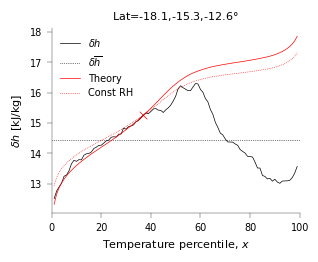

In [491]:
lat_use_h_plot = lat_use[:3]
delta_h_non_conv = np.asarray([(mse_quant3[1]-mse_quant3[0])[0, j, x_non_conv_lat_ind[1, j]] for j in range(n_lat)])
delta_h_non_conv_theory = np.asarray([delta_h_non_conv[j, np.newaxis] + \
                          delta_d_epsilon_d_temp_theory_lat[j, np.newaxis] * (temp_quant3[0, 0, j]-
                                                                          temp_quant3[0, 0, j, x_non_conv_lat_ind[1, j], np.newaxis]) for j in range(n_lat)])
delta_h_non_conv_theory_no_rh = np.asarray([delta_h_non_conv[j, np.newaxis] + \
                          delta_d_epsilon_d_temp_cont_lat[-1][j, np.newaxis] * (temp_quant3[0, 0, j]-
                                                                          temp_quant3[0, 0, j, x_non_conv_lat_ind[1, j], np.newaxis]) for j in range(n_lat)])

save_delta_h_theory = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average((mse_quant3[1]-mse_quant3[0])[0, lat_use_h_plot], axis=0, weights=lat_weights[lat_use_h_plot]), 
        color='k', label='$\delta h$')
ax.axhline(np.average((mse_mean[1]-mse_mean[0])[0, lat_use_h_plot], axis=0, weights=lat_weights[lat_use_h_plot]), color='k', linestyle=':', 
           label='$\delta \overline{h}$')
ax.scatter(np.average(quant_plot[x_non_conv_lat_ind[1, lat_use_h_plot]], axis=0, weights=lat_weights[lat_use_h_plot]), 
           np.average(delta_h_non_conv[lat_use_h_plot], axis=0, weights=lat_weights[lat_use_h_plot]), 
           color='r', marker='x', s=30)
ax.plot(quant_plot, np.average(delta_h_non_conv_theory[lat_use_h_plot], axis=0, weights=lat_weights[lat_use_h_plot]), color='r', label='Theory')
ax.plot(quant_plot, np.average(delta_h_non_conv_theory_no_rh[lat_use_h_plot], axis=0, weights=lat_weights[lat_use_h_plot]),
        color='r', linestyle=':', label='Const RH')
ax.legend()
ax.set_title(f"Lat={','.join(map(str, np.round(ds_all[0].lat[lat_use_h_plot].to_numpy(), 1)))}$\degree$")
ax.set_xlim(0, 100)
ax.set_ylabel('$\delta h$ [kJ/kg]')
ax.set_xlabel(percentile_label)
if save_fig or save_delta_h_theory:
    fig.savefig(f"/Users/joshduffield/Desktop/delta_h_theory_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

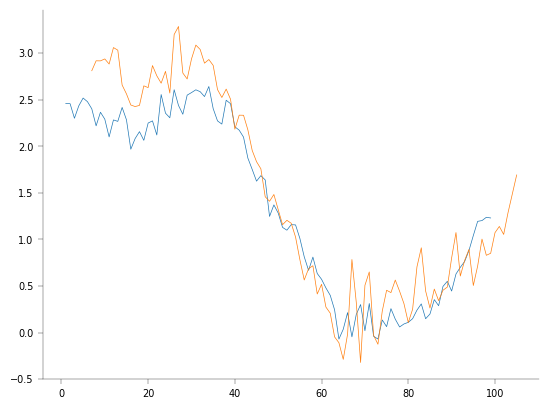

In [258]:
for i in range(2):
    plt.plot(quant_plot+i*6, np.gradient(np.average(epsilon_quant3[i, lat_use], axis=0, weights=lat_weights_use), 
                                     np.average(temp_quant3[i, 0, lat_use], axis=0, weights=lat_weights_use)))

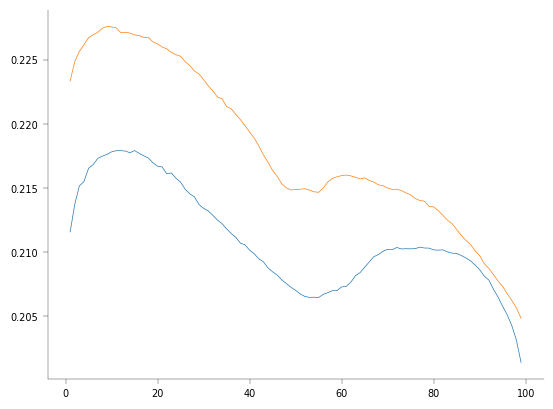

In [109]:
for i in range(n_exp):
    plt.plot(quant_plot, np.average(r_quant3[i], weights=lat_weights, axis=0))

### High percentiles as function of latitude
In the plot below, the quantiles in the order $90, 95, 99$ are represented in terms of lines of increasing opacity i.e. the darkest lines represent $x=99$.

In [27]:
def abs_lat_av(var):
    # averages across indices with the same absolute latitude
    var_av = np.zeros(int(len(var)/2))
    for i in range(len(var_av)):
        var_av[i] = np.mean([var[i], var[-1-i]])
    return var_av[::-1]     # invert order so latitude is increasing

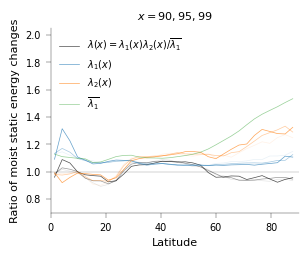

In [28]:
quant_subset = [90,95,99]
# quant_subset = [10,5,1]
quant_subset_ind = numpy_indexed.indices(quant_plot, quant_subset)
quant_subset_alpha = [0.1+i*(0.9/len(quant_subset)) for i in range(len(quant_subset))]
lat_plot = ds_all[0].lat[int(n_lat/2):]

save_lambda_decomp_lat_fig = False
fig_lambda_decomp, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.spines[['right', 'top']].set_visible(False)
for i, var in enumerate([lambda_1*lambda_2/np.expand_dims(lambda_3, axis=-1), lambda_1, lambda_2]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[0]]), alpha=quant_subset_alpha[0], color=use_color)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[1]]), alpha=quant_subset_alpha[1], color=use_color)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[2]]), alpha=quant_subset_alpha[2], color=use_color, label=labels[i])
ax.plot(lat_plot, abs_lat_av(lambda_3), color=default_colors[2], alpha=0.5, label=labels[3])
ax.hlines(1, -90, 90, color='k', alpha=0.5, lw=ax_linewidth)
ax.set_xlim(0, 90)
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Ratio of moist static energy changes')
ax.set_title('$x=90, 95, 99$')
# ax.set_title('$x=10, 5, 1$')
ax.set_ylim(0.7,2.05)
if (save_fig or save_lambda_decomp_lat_fig):
    fig_lambda_decomp.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_lat_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### $\lambda_2$ Decomposition
$\lambda_2(x) = \delta h_{FT, sat}(x) / \delta \overline{h}_{FT, sat}$ can be split up into a product of two terms:
$$\lambda_2(x) = \frac{c_p+L_v\alpha(T_{FT}(x))q^*(T_{FT}(x))}{c_p+L_v\alpha(\overline{T_{FT}})q^*(\overline{T_{FT}})} \times
\frac{\delta T_{FT}(x)}{\delta \overline{T_{FT}}$$
The first term being just evaluated at the historical simulation, and the second incorporating temperature changes. This equation assumes no changes to the geopotential height term, but in zhang 2023, these can be related to temperature as well.
I label these contributions as $\lambda_{2_0}$ and $\lambda_{2_{\delta}}$ respectively.

The black and blue lines below differ, indicating that the geopotential height or potentialy squared temperature, $\delta T^2$ terms may be important.

In [76]:
lambda_2_0 = (c_p + L_v * clausius_clapeyron_factor(temp_quant3[0, 1], pressure_ft_actual) *
              sphum_sat(temp_quant3[0, 1], pressure_ft_actual)) / np.expand_dims(
    c_p + L_v * clausius_clapeyron_factor(temp_mean[0, 1], pressure_ft_actual) * sphum_sat(temp_mean[0, 1], pressure_ft_actual), axis=-1)

# Include change in height term that we assume is proportional to temperature change
lambda_2_0z = (c_p + L_v * clausius_clapeyron_factor(temp_quant3[0, 1], pressure_ft_actual) *
              sphum_sat(temp_quant3[0, 1], pressure_ft_actual)) / np.expand_dims(
    c_p + L_v * clausius_clapeyron_factor(temp_mean[0, 1], pressure_ft_actual) * sphum_sat(temp_mean[0, 1], pressure_ft_actual) + 
    (ds_all[0].height / ds_all[0].temp).mean(dim='lon_time')[-1] * 9.81, axis=-1)
lambda_2_0z_const = (ds_all[0].height / ds_all[0].temp).mean(dim='lon_time')[-1] * 9.81 / (
    c_p + L_v * clausius_clapeyron_factor(temp_mean[0, 1], pressure_ft_actual) * sphum_sat(temp_mean[0, 1], pressure_ft_actual) + 
    (ds_all[0].height / ds_all[0].temp).mean(dim='lon_time')[-1] * 9.81)
# lambda_2_0 = lambda_2_0 + np.expand_dims((9.81*ds_all[0].height[1].mean(dim='lon_time')/temp_mean[0, 1]) / (c_p + L_v * clausius_clapeyron_factor(temp_mean[0, 1], pressure_ft_actual) * sphum_sat(temp_mean[0, 1], pressure_ft_actual)), axis=-1)
# lambda_z = temp_quant3[0, 1]*9.81*np.expand_dims(ds_all[0].height[1].mean(dim='lon_time'), axis=-1)/np.expand_dims(temp_mean[0, 1]**2*(c_p + L_v * clausius_clapeyron_factor(temp_mean[0, 1], pressure_ft_actual) * sphum_sat(temp_mean[0, 1], pressure_ft_actual)), axis=-1)
lambda_2_delta = (temp_quant3[1]-temp_quant3[0])[1]/np.expand_dims(temp_mean[1]-temp_mean[0], axis=-1)[1]

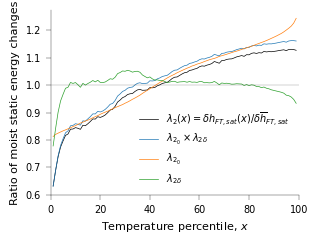

In [79]:
save_lambda2_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
labels_lambda2 = ['$\lambda_2(x) = \delta h_{FT, sat}(x) / \delta \overline{h}_{FT, sat}$',
                  '$\lambda_{2_0} \\times \lambda_{2\delta}$', '$\lambda_{2_0}$', '$\lambda_{2\delta}$']
for i, var in enumerate([lambda_2, lambda_2_0 * lambda_2_delta, lambda_2_0, lambda_2_delta]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(quant_plot, np.average(var[lat_use], axis=0, weights=lat_weights_use),
            color=use_color, label=labels_lambda2[i])
# ax.plot(quant_plot, np.average(lambda_2_0z, axis=0, weights=lat_weights), color='grey')
# ax.plot(quant_plot, np.average(lambda_2_0z * lambda_2_delta + np.expand_dims(lambda_2_0z_const, -1), axis=0, weights=lat_weights), color='grey')
# ax.plot(quant_plot, np.average(lambda_2, axis=0, weights=lat_weights), color=default_colors[1])
ax.hlines(1, 0, 100, color='k', alpha=0.5, lw=ax_linewidth)
ax.legend()
ax.set_xlim(0, 100)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Ratio of moist static energy changes')
if save_fig or save_lambda2_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda2_decomp_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

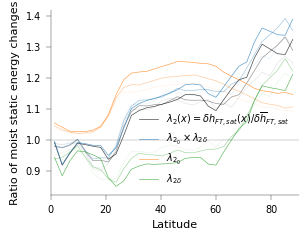

In [31]:
save_lambda2_decomp_lat_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i, var in enumerate([lambda_2, lambda_2_0 * lambda_2_delta, lambda_2_0, lambda_2_delta]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[0]]), alpha=quant_subset_alpha[0], color=use_color)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[1]]), alpha=quant_subset_alpha[1], color=use_color)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[2]]), alpha=quant_subset_alpha[2], color=use_color, label=labels_lambda2[i])
ax.hlines(1, -90, 90, color='k', alpha=0.5, lw=ax_linewidth)
ax.set_xlim(0, 90)
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Ratio of moist static energy changes')
if (save_fig or save_lambda2_decomp_lat_fig):
    fig.savefig(f"/Users/joshduffield/Desktop/lambda2_decomp_lat_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

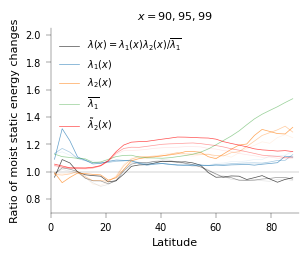

In [32]:
save_lambda_decomp_lat_fig2 = False
fig = copy.deepcopy(fig_lambda_decomp)
ax = fig.gca()
for i in range(len(quant_subset)):
    ax.plot(lat_plot, abs_lat_av(lambda_2_0[:, quant_subset_ind[i]]), color='r', 
            label='$\\tilde{\lambda}_2(x)$' if i==len(quant_subset)-1 else None, alpha=quant_subset_alpha[i] )
ax.legend()
if (save_fig or save_lambda_decomp_lat_fig2):
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_lat2_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, pad_inches=save_pad_inches)
fig

### Add $\lambda_{2_0}$ to theory
The orange line in the theory below assumes that $\lambda_1 = \lambda_3$ and $\lambda_2 = \lambda_{2_0}$. These combine to give $\lambda = \lambda_{2_0}$ rather than $\lambda=1$.

This seems to improve things at higher latitudes but only because the $\lambda_1 = \lambda_3$ approximation breaks down in the opposite way so you get cancellation of errors.
I.e. we assume that $\lambda_3 \approx \lambda_1$ and $\lambda_2 \approx \lambda_{2_0}$. When actually at high latitudes, $\lambda_3 > \lambda_1$ and $\lambda_2 > \lambda_{2_0}$. Because $\lambda = \lambda_1 \lambda_2 / \lambda_3$, if we underestimate both $\lambda_3$ and $\lambda_2$, then these effects offset each other.

In [33]:
# Obtain surface quantities required for theories
sphum_mean = np.zeros((n_exp, n_lat))
# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = np.zeros((n_exp, n_lat, n_quant))
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = np.zeros((n_exp, n_lat, n_quant))
# mse as function of mse quantile not temp quantile
mse_quant2 = np.zeros((n_exp, n_lat, n_quant))

for i in tqdm(range(n_exp)):
    ds_use = ds_all[i].sel(pfull=p_surface/100)
    sphum_mean[i] = ds_use.sphum.mean(dim='lon_time')
    temp_quant2[i] = ds_use.temp.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
    sphum_quant2[i] = ds_use.sphum.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
    mse = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)
    mse_quant2[i] = mse.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()

temp_diff_theory = {method: np.zeros((n_lat, n_quant)) for method in ['linear', 'lambda_2']}
for method in temp_diff_theory:
    for i in range(n_lat):
        temp_diff_theory[method][i] = \
            get_delta_temp_quant_theory(temp_mean[:, 0, i], sphum_mean[:, i], temp_quant2[:, i], sphum_quant2[:, i], p_surface,
                                        const_rh=False, delta_mse_ratio=lambda_2_0[i:i+1] if 'lambda' in method else None,
                                        taylor_level='linear_rh_diff')
delta_mse_ratio = (mse_quant2[1]-mse_quant2[0])/np.expand_dims((mse_mean[1]-mse_mean[0])[0], axis=-1)

100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


In [34]:
scaling_factor_av = 'mean'    # Mean will use quantile closest to mean at each latitude
# scaling_factor_av = 'median'  # take median as average rather than mean because theory does not predict change to mean temperature
# scaling_factor_av_type = 'theory'
scaling_factor_av_type = 'simulated'     # If 'simulated', will use theoretical mean/median temp diff to compute theoretical scale factor too

av_quant_ind = np.where(quant_plot==50)[0]
if scaling_factor_av == 'mean':
    # Find temperature quantile if historical climate closest to mean
    av_quant_ind = [int(np.round(scipy.stats.percentileofscore(ds_all[0].temp[0][i], float(ds_all[0].temp[0][i].mean())))) 
                    for i in range(n_lat)]
else:
    av_quant_ind = [50]*n_lat
av_quant_ind = numpy_indexed.indices(quant_plot, np.asarray(av_quant_ind))
av_quant_flat_ind = np.ravel_multi_index((np.arange(n_lat), av_quant_ind), temp_quant2[0].shape)
sf_denom = {key: temp_diff_theory[key].flatten()[av_quant_flat_ind] for key in temp_diff_theory.keys()}
if scaling_factor_av == 'mean':
    sf_denom['simulated'] = temp_mean[1, 0]-temp_mean[0, 0]
else:
    sf_denom['simulated'] = (temp_quant2[1]-temp_quant2[0]).flatten()[av_quant_flat_ind]
for key in sf_denom:
    sf_denom[key] = np.expand_dims(sf_denom[key], axis=-1)
    
if scaling_factor_av_type == 'simulated':
    for key in temp_diff_theory.keys():
        # Set all theoretical mean/median predictions to the simulated
        sf_denom[key] = sf_denom['simulated'] 

ValueError: cannot convert float NaN to integer

In [ ]:
save_lambda2_theory_fig = False
fig, ax = plt.subplots(3,1, figsize=(width['one_col'], 0.75*3*width['one_col']/ar), sharex=True)
ax[0].plot(quant_plot, np.average((temp_quant2[1]-temp_quant2[0])[lat_use], axis=0, weights=lat_weights_use), 
           label = 'Simulated', color='blue')
ax[0].plot(quant_plot, np.average(temp_diff_theory['linear'][lat_use], axis=0, weights=lat_weights_use), color='k', linestyle='--',
           label='Original theory')
ax[0].plot(quant_plot, np.average(temp_diff_theory['lambda_2'][lat_use], axis=0, weights=lat_weights_use), color=default_colors[1],
           label='Modified theory')
ax[1].plot(quant_plot, 
           np.average((temp_quant2[1]-temp_quant2[0])[lat_use]/sf_denom['simulated'][lat_use],
                                  axis=0, weights=lat_weights_use), label = 'Simulated', color='b')
ax[1].plot(quant_plot, np.average(temp_diff_theory['linear'][lat_use]/sf_denom['linear'][lat_use], 
                                  axis=0, weights=lat_weights_use), color='k', linestyle='--')
ax[1].plot(quant_plot, np.average(temp_diff_theory['lambda_2'][lat_use]/sf_denom['lambda_2'][lat_use], 
                                  axis=0, weights=lat_weights_use), color=default_colors[1])
# Add lambda comparison
for i, var in enumerate([delta_mse_ratio, lambda_2_0]):
    ax[2].plot(quant_plot, np.average(var[lat_use], axis=0, weights=lat_weights_use),
            color='b' if i == 0 else default_colors[1], label='$\lambda$' if i==0 else '$\lambda_{2_0}$')
ax[1].hlines(1, -10, 100, color='k', alpha=0.5, linewidth=ax_linewidth)
ax[2].hlines(1, -10, 100, linestyles='--', color='k')
ax[2].set_ylabel('Ratio of moist static energy changes')
ax[2].legend()
ax[0].legend()
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('$\delta T(x)$ / $K$')
ax[1].set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax[0].set_xlim(0,100)
# ax[0].set_ylim(4,12)
# ax[1].set_ylim(0.55,1.6)
# ax[2].set_ylim(0.75,1.5)

if save_fig or save_lambda2_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_lambda2_theory_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [ ]:
save_theory_lambda2_lat_fig = False
norm_by_sf = True
if norm_by_sf:
    denom = {key: sf_denom[key].flatten() for key in sf_denom}
else:
    denom = {key: 1 for key in sf_denom}
include_theory = True
fig_theory_lat, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(len(quant_subset)):
    ax.plot(lat_plot, abs_lat_av((temp_quant2[1, :, quant_subset_ind[i]]-temp_quant2[0, :, quant_subset_ind[i]])/
                                 denom['simulated']), color='r', alpha=quant_subset_alpha[i],
            label='Simulated' if i==2 else None)
    if include_theory:
        ax.plot(lat_plot, abs_lat_av(temp_diff_theory['linear'][:, quant_subset_ind[i]]/
                                     denom['linear']), color='k', alpha=quant_subset_alpha[i],
                label='Original theory' if i==2 else None)
        ax.plot(lat_plot, abs_lat_av(temp_diff_theory['lambda_2'][:, quant_subset_ind[i]]/
                         denom['lambda_2']), color=default_colors[2], alpha=quant_subset_alpha[i],
        label='Modified theory' if i==2 else None)
ax.set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax.set_xlabel('Latitude')
if include_theory:
    ax.legend(frameon=False)
ax.set_xlim(0,90)
# ax.set_ylim(0.4, 1.05)
if (save_fig or save_theory_lambda2_lat_fig):
    fig_theory_lat.savefig(f"/Users/joshduffield/Desktop/temp_theory_lambda2_lat_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)